# Analyse des ressentis avec GloVe Vectors

L'analyse des ressentis a pour objectif de classifier les opinions exprimées sous forme de texte dans un langage naturel. Différentes méthodes peuvent être utlisées pour réaliser cette analyse. Dans cet exemple, des commentaires recueillis surle site [allociné](http://www.allocine.fr/) vont être utlisés pour entrainer un modèle de classification supervisé. Le modèle utilise un réseau de neurones à convolution 1D.

Les mots contenus dans les phrases doivent être encodés dans des vecteurs qui seront utilisés pour l'entrainement et les tests. Une manière simple serait d'assigner à chaque mot une valeur numérique. Le problème de cette méthode est que le contexte dans lequel les mots sont utilisés n'est pas pris en compte. Une méthode permettant de combler ce manque est d'utiliser un algorithme de prolongation lexicale (Word embedding). Parmi ce genre d'algorithme, on trouve [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/) qui se base sur les probabilités de co-occurence de mots. Une base de données pré-entrainée (mais en Anglais) est déjà disponnible sur leur site web.  

Une base de donnée pré-entrainée en Français peut-être néanmoins téléchargée à cette [adresse](http://www.cs.cmu.edu/~afm/projects/multilingual_embeddings.html). C'est celle-ci que nous utiliserons.

In [1]:
import pandas as pd
import numpy as np
import random
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Chargement des données d'entrainement

Les données d'entrainement sont chargées dans une dataframe Panda depuis des fichiers textes. Ces données contiennent deux colonnes : Un commentaire et une valeur binaire définissant un sentiment négatif ou positif sur ce commentaire. 

Ces données sont disponnibles sur le github de [TheophileBlard](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/tree/master/allocine_dataset). Ces données sont issues de commentaires récupérés sur Allociné. Les utilisateurs votent avec des notes allant de 0.5 à 5.0 :    
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/rating_counts.png?raw=1" width="600"/>

Afin de récupérer une note binaire (négative ou positive) à partir de cet intervalle de valeurs, les votes <= 2 sont classé comme négatifs et ceux >=4 sont classés comme positifs. Les autres sont classés comme neutres :    
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/polarity_frequency.png?raw=1" width="600"/>  
  

Enfin, pour construire les données, 100 000 avis négatifs et 100 000 avis positifs sont extraits aléatoirement, puis décomposés en deux catégories : Les données d'entrainement (80%), les données de test (10%) et les données de validation (10%) :  
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/splits_polarity.png?raw=1" width="600"/>  



In [2]:
# Téléchargement des données depuis le repot github "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"

!wget "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"
!tar -xjvf data.tar.bz2
!ls -l data

--2020-09-12 12:16:04--  https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2 [following]
--2020-09-12 12:16:05--  https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66625305 (64M) [application/octet-stream]
Saving to: ‘data.tar.bz2’

data.tar.bz2        100%[===================>]  63.54M   164MB/s    in 0.4s    

2020-09-12 12:

In [3]:
DataEntrainement = pd.read_json("/content/data/test.jsonl", lines=True)
DataEntrainement.head(10)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/cr...,"Magnifique épopée, une belle histoire, touchan...",1
1,http://www.allocine.fr/film/fichefilm-1954/cri...,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,http://www.allocine.fr/film/fichefilm-135523/c...,Un dessin animé qui brille par sa féerie et se...,1
3,http://www.allocine.fr/film/fichefilm-61514/cr...,"Si c'est là le renouveau du cinéma français, c...",0
4,http://www.allocine.fr/film/fichefilm-260395/c...,Et pourtant on s’en Doutait !Second volet très...,0
5,http://www.allocine.fr/film/fichefilm-220641/c...,Vous reprendrez bien un peu d'été ? Ce film je...,1
6,http://www.allocine.fr/film/fichefilm-120103/c...,Bon c'est pas un grand film mais on passe un b...,1
7,http://www.allocine.fr/film/fichefilm-190956/c...,"Terrible histoire que ces êtres sans amour, ce...",1
8,http://www.allocine.fr/film/fichefilm-186185/c...,"Un très joli film, qui ressemble à un téléfilm...",1
9,http://www.allocine.fr/film/fichefilm-17327/cr...,Mais comment certaines personnes ont pus lui m...,0


# Chargement des vecteurs GloVE et création des matrices

Nous allons charger les vecteurs GloVE et créer des matrices à partir de ceux-ci.

Les fichiers des vecteurs GloVe sont téléchargés à partir du site de [GloVe](https://nlp.stanford.edu/projects/glove/) mais ils sont en Anglais. Nous allons utiliser une [version française](http://www.cs.cmu.edu/~afm/projects/multilingual_embeddings.html) équivalente.  
  
Le fichier que nous utilisons contient plus de 40000 vecteurs de dimension 300. Cela signifie que pour chaque mot contenu dans ce fichier, un vecteur de 300 valeurs permet de définir les relations lexicales de ce mots avec les autres mots du fichier.  
    
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/EmbeddedVectors.png?raw=1" width="1200"/>  

In [ ]:
# Téléchargement des vecteurs
!wget "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/multilingual_embeddings.rar"
!mv multilingual_embeddings.rar /content/data/multilingual_embeddings.rar
!unrar x /content/data/multilingual_embeddings.rar /content/data


On définit maintenant deux fonctions :  
* La fonction Chargement_Vecteurs() va créer un tableau de type numpy, avec pour chaque mot son vecteur correspondant :  



```
  ...
  'embêtant': array([-2.26152748e-01,  3.20324749e-01, -1.10406213e-01, -6.05279326e-01,
        -4.68072683e-01,  1.29561171e-01,  5.62916815e-01, -1.16834176e+00,
       ...
        -7.50736117e-01, -2.48611599e-01, -2.42264550e-02, -9.54209745e-01],
       dtype=float32),
 'lockheed': array([ 3.6074609e-01, -8.0667698e-01,  8.7549436e-01,  6.2351477e-01,
        -9.2155904e-01,  7.3180795e-01, -2.8121206e-01,  2.9078028e-01,
        ...
         1.5100185e+00,  8.1941241e-01, -1.6970781e+00,  1.9289741e-01],
       dtype=float32),
 'séparez': array([-0.5703459 , -0.8884122 , -0.4579496 ,  0.55588883, -0.8727098 ,
         0.56783265, -0.10067926,  0.14027229, -0.89301944, -0.42706665,
        ...
        -0.36254016, -0.40695533,  1.087127  , -0.641696  ,  0.10919298,
```



In [54]:
MAX_NB_WORDS = 1000000
MAX_NB_VECTORS = 5
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 300

num_classes = 2

def Chargement_Vecteurs():
    print('Chargement des vecteurs GloVe...')
    glove_dict = {}
    Max_Nb_Vect = 0
    with open('/content/data/multilingual_embeddings.fr', encoding='utf8') as fichier:
        for ligne in fichier:
            Max_Nb_Vect = Max_Nb_Vect + 1
            if Max_Nb_Vect > MAX_NB_VECTORS:
              break
            valeur = ligne.split()
            mot = valeur[0]
            glove_dict[mot] = np.asarray(valeur[1:], dtype='float32')
    return glove_dict

def creation_matrice(index_mot, nbr_mots):
    glove_dict = Chargement_Vectors()
    matrice = np.zeros((nbr_mots, EMBEDDING_DIM))
    for mot, i in index_mot.items():
        if i > nbr_mots:
            continue
        vector = glove_dict.get(mot)
        if vector is not None:
            matrice[i] = vector
    return matrice

In [55]:
data_glove = Chargement_Vecteurs()

Chargement des vecteurs GloVe...


In [56]:
data_glove

{'bourrés': array([-0.8433598 , -0.10593044, -0.34571698, -1.1293168 ,  0.28852624,
         0.6322153 ,  0.16338542,  0.8659194 ,  0.84873366,  1.1048244 ,
         0.1532723 ,  0.43684915,  0.27500245,  0.23346229, -1.1731404 ,
        -1.1109859 , -0.15025046,  1.0603158 , -1.3339813 ,  3.3396902 ,
         0.8823968 ,  0.18630008, -1.1698588 ,  1.2097162 ,  0.24811314,
        -0.3793616 , -0.4891553 ,  2.3405263 ,  1.6838933 ,  0.9294254 ,
         2.1211586 ,  0.42782134,  1.4641168 ,  0.68279445,  0.5165373 ,
        -0.09145662,  1.0467978 ,  2.4008772 ,  0.9608098 ,  2.2901895 ,
        -0.49484292, -0.16240674,  0.98893553,  0.0633358 , -0.27702934,
         0.24270007,  0.28713596, -0.06889176,  1.3822082 , -0.49942413,
         1.0031114 , -0.2583637 , -2.7895212 ,  0.02822703, -1.0116721 ,
        -1.9544768 ,  0.67724836, -0.11221939,  0.17958365,  0.03454317,
         0.8045084 , -0.01086469, -0.29314598,  1.0164337 , -2.2324164 ,
         0.52757394, -3.704143  ,  0.213

In [ ]:
matrice = creation_matrice(word_index, num_words)

# Encodage du Texte

In [ ]:
comments = trainingData.comment.astype(str).tolist()
sentiments = trainingData.sentiment.tolist()
labels = np.asarray(sentiments)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index

num_words = min(MAX_NB_WORDS, len(word_index)) + 1

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

In [ ]:
embedding_matrix = create_embedding_matrix(word_index, num_words)

Loading glove vectors...


# Définition du Modèle

This is a 1D CNN model with a Keras embedding layer using the embedding matrix created above. The embedding layer is pre-trained, so it will not be trained here.

In [ ]:
dropout = 0.4

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(dropout))

model.add(Conv1D(128, 5, activation='relu', padding='same', strides=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout))

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          263600    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 128)          32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

Epoch 1/40
18/18 [==============================] - 5s 294ms/step - loss: 0.8190 - acc: 0.5182 - val_loss: 0.6636 - val_acc: 0.6200
Epoch 2/40
18/18 [==============================] - 5s 280ms/step - loss: 0.7283 - acc: 0.5214 - val_loss: 0.6692 - val_acc: 0.5945
Epoch 3/40
18/18 [==============================] - 5s 279ms/step - loss: 0.6887 - acc: 0.5710 - val_loss: 0.6656 - val_acc: 0.6436
Epoch 4/40
18/18 [==============================] - 5s 277ms/step - loss: 0.6721 - acc: 0.5892 - val_loss: 0.6436 - val_acc: 0.6618
Epoch 5/40
18/18 [==============================] - 5s 279ms/step - loss: 0.6505 - acc: 0.6228 - val_loss: 0.6472 - val_acc: 0.6527
Epoch 6/40
18/18 [==============================] - 5s 279ms/step - loss: 0.6450 - acc: 0.6397 - val_loss: 0.6175 - val_acc: 0.7145
Epoch 7/40
18/18 [==============================] - 5s 278ms/step - loss: 0.6255 - acc: 0.6451 - val_loss: 0.6004 - val_acc: 0.7145
Epoch 8/40
18/18 [==============================] - 5s 278ms/step - loss: 0.

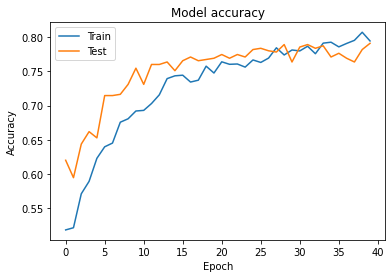

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

# Train model for a given number of epochs
history = model.fit(x_train, y_train, batch_size=128, epochs=40, verbose=1, validation_data=(x_test, y_test))

# Evaluate model against test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
predictions = model.predict(padded_sequences)
most_likely = predictions.argmax(1)

In [ ]:
index = random.randrange(len(predictions))
print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

The script is bad, very bad  it contains both cheesiness and unethical joke that you normally see in rated R or NC-17 movie.  
Prediction: 0, label: 0


# Error Analysis

You get extra minutes so that you can carry out the call and not get cut off."
Prediction: 0, label: 1


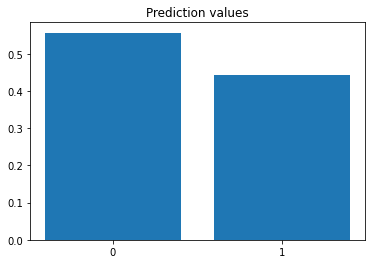

In [ ]:
for i in range(10000):
    index = random.randrange(len(predictions))
    if most_likely[index] != sentiments[index]:
        break

print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

plt.bar(range(num_classes), predictions[index], tick_label=range(num_classes))
plt.title('Prediction values')
plt.show()